In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd

from os import listdir
from os.path import isfile, join

import shutil

import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import shap

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/Users/s1suu/Library/Python/3.9/lib/python/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/s1suu/Library/Python/3.9/lib/python/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(

<Axes: xlabel='dx'>

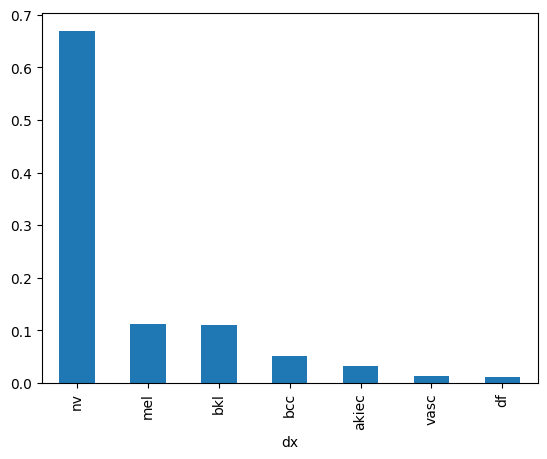

In [23]:
df = pd.read_csv('../data/HAM10000_metadata.csv')
df.head()

filtered = df.iloc[list(range(0, len(df), 2)),:].copy().reset_index(drop = True)
filtered.head()

filtered['dx'].value_counts(normalize = True).plot(kind = 'bar')

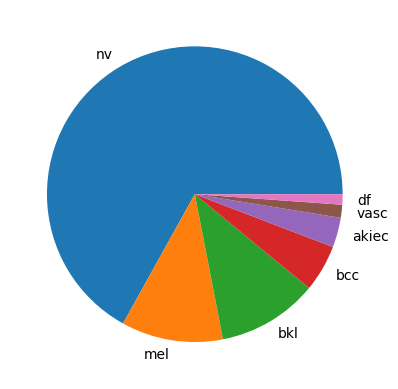

In [24]:
filtered['dx'].value_counts(normalize = True).plot(kind = 'pie')
plt.ylabel(None)
plt.show()

In [50]:
label_encoding = sorted(list(filtered['dx'].unique()))
label_encoding

#############Enablefor mving files #################

# image_labels = dict(zip(filtered['image_id'], filtered['dx']))

# train_path = '../data/all_images'
# onlyfiles = [f for f in listdir(train_path) if isfile(join(train_path, f))]

# for i in filtered['image_id']:
#     source = train_path + "/" + i + '.jpg'
#     dest = train_path + "/" + image_labels[i] + "/" + i + '.jpg'
#     print(source)
#     print(dest)
#     shutil.copy(source, dest)

../data/all_images/ISIC_0027419.jpg
../data/all_images/bkl/ISIC_0027419.jpg


FileNotFoundError: [Errno 2] No such file or directory: '../data/all_images/ISIC_0027419.jpg'

In [29]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    # preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    # preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    # preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    # preprocessing.RandomRotation(factor=0.20),
    # preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

**# NN Creation**

In [30]:
tf.device("/gpu:0")

In [31]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../data/binary_class',
    labels='inferred',
    label_mode='binary',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=8,
    shuffle=False,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'training',
    seed = 1
)
ds_valid_ = image_dataset_from_directory(
    '../data/binary_class',
    labels='inferred',
    label_mode='binary',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=8,
    shuffle=True,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'validation',
    seed = 1
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5008 files belonging to 2 classes.
Using 4007 files for training.
Found 5008 files belonging to 2 classes.
Using 1001 files for validation.


In [67]:
model3 = keras.Sequential([
    layers.InputLayer(input_shape=[600, 450, 3]),
    
    # Block One
    #layers.experimental.preprocessing.Rescaling(scale = 1./255),
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    
    # output
    layers.Dense(1, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(epsilon = 0.01)
model3.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Ba  (None, 600, 450, 3)       21        
 tchNormalization)                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 596, 446, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 298, 223, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_11 (Ba  (None, 298, 223, 32)      224       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 294, 219, 32)      25632     
                                                      

In [68]:
save = 0

In [69]:
if save == 1:
    history = model3.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=1,
        use_multiprocessing=True,
        class_weight = {0:1, 1:7}
    )
    model3.save_weights('model3')
else:
    model3.load_weights('model3')

In [70]:
predictions = []
labels =  []
for x, y in ds_train:
    predictions = predictions + model3.predict(x).tolist()
    labels = labels + y.numpy().tolist()

1/1 [==============================] - 0s 373ms/step


In [71]:
predictions = [x[0] for x in predictions]
labels = [x[0] for x in labels]

In [72]:
temp_train = pd.DataFrame({
    'prob' : predictions,
    'label':labels
})

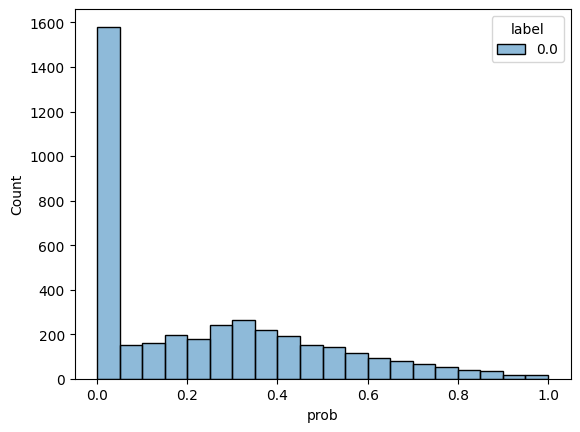

In [73]:
sns.histplot(data = temp_train, x = 'prob', hue = 'label')
plt.show()

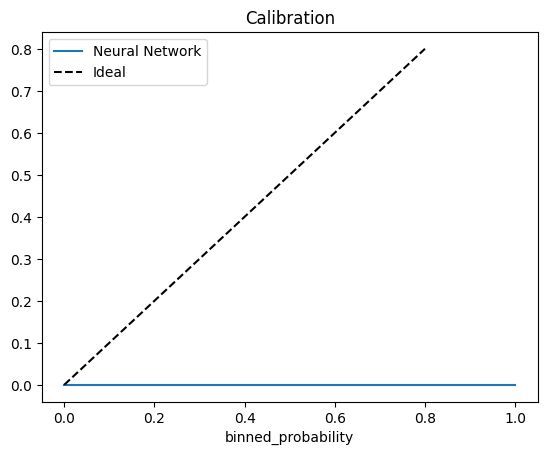

In [74]:
nbins = 10
bins = list(range(0, 100, int(100 / nbins)))
bins = [b/100 for b in bins]

def create_bins(p):
    for i in range(nbins):
        if i == nbins - 1:
            if (p > bins[i]) and (p < 1):
                return bins[i]
            else:
                return 1
        if (p > bins[i]) and (p < bins[i+1]):
            return bins[i]
    return 0

temp_train['binned_probability'] = temp_train['prob'].apply(create_bins)
temp_train.groupby('binned_probability')['label'].mean().plot(label = 'Neural Network')
plt.plot([0, 0.8] , [0, 0.8], 'k--',label = 'Ideal')
plt.title("Calibration")
plt.legend()
plt.show()

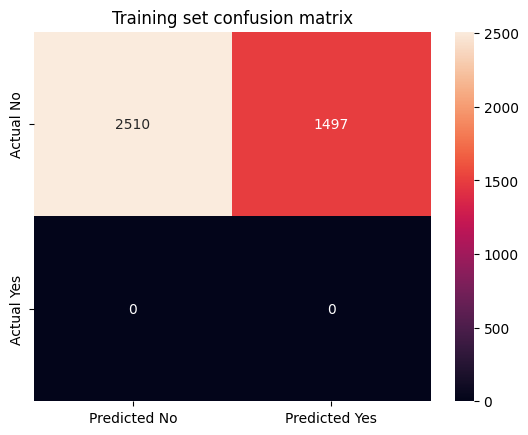

In [75]:
predicted_class = [1 if p > 0.3 else 0 for p in predictions]
confusion_matrix(y_true=labels, y_pred=predicted_class)
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predicted_class),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Training set confusion matrix")
plt.show()

1/1 [==============================] - 0s 63ms/step


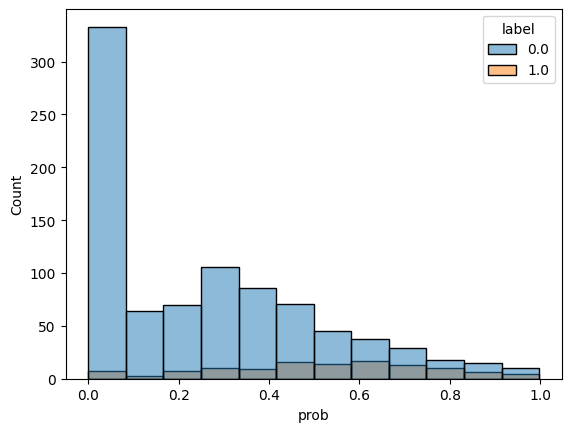

In [76]:
predictions = []
labels =  []
for x, y in ds_valid:
    predictions = predictions + model3.predict(x).tolist()
    labels = labels + y.numpy().tolist()
predictions = [x[0] for x in predictions]
labels = [x[0] for x in labels]
temp = pd.DataFrame({
    'prob' : predictions,
    'label':labels
})
sns.histplot(data = temp, x = 'prob', hue = 'label')
plt.show()

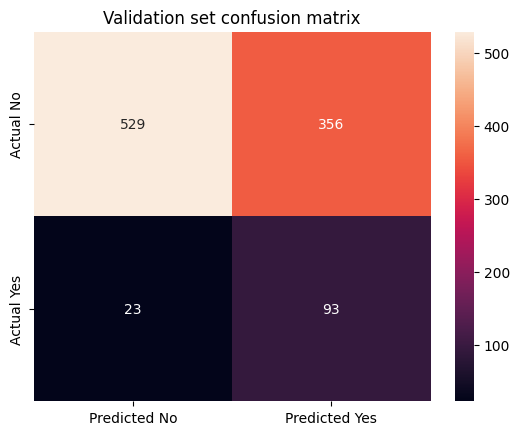

In [77]:
predicted_class = [1 if p > 0.3 else 0 for p in predictions]
confusion_matrix(y_true=labels, y_pred=predicted_class)
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predicted_class),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Validation set confusion matrix")
plt.show()

**# Check Cascading**

In [78]:
temp = temp_train.copy()

In [79]:
no_class = '../data/binary_class/0'
no_class_names = [f for f in listdir(no_class) if isfile(join(no_class, f))]
yes_class = '../data/binary_class/1'
yes_class_names = [f for f in listdir(yes_class) if isfile(join(yes_class, f))]
len(no_class_names+yes_class_names)

5008

In [80]:
len(no_class_names), len(yes_class_names)
temp.head()

,prob,label,binned_probability
0,4.116417e-01,0.0,0.4
1,1.612780e-10,0.0,0.0
2,9.179585e-11,0.0,0.0
3,3.915624e-01,0.0,0.3
4,2.394161e-01,0.0,0.2


In [88]:
temp["image_id"] = pd.Series([no_class_names, yes_class_names])
temp = temp.fillna(0)

In [89]:
temp['image_id'] = no_class_names+yes_class_names
temp['image_id'] = temp['image_id'].str.split('.', expand = True)[0]
temp.head()

ValueError: Length of values (5008) does not match length of index (4007)

In [ ]:
cascade = filtered.merge(temp, on = 'image_id')
cascade.head()